## Aspect-Based Emotion Analysis on Twitter Data



In a further step, a **more fine-grained** approach can be taken to ABSA, namely the classifcation of emotions rather than sentiments.

##### Re-Training GRACE for emotions using the Twemlab Goldstandard

The twemlab goldstandard files are already labelled according to emotions. In this notebook they are consolidated into the four basic emotions:
- happiness (includes love and beauty) 🙂
- anger (includes disgust) 😠
- sadness 😞
- fear 😨

Aside from the consolidation of the emotion labels, this notebook uses helper functions to label each tweet according to its emotion-related aspect terms. The function splits the datasets into chunks of 100 tweets to save each annotated chunk during the process (for extra caution that the annotations are saved). Each tweet is shown to the user along with the labelled emotion. The user can enter how many aspect terms there are and then enters the aspect terms. The function then automatically identifies the beginning and inside of aspect terms and labels them according to the required input format of the GRACE model developed by [Luo et al. (2020)](https://arxiv.org/abs/2009.10557).

For clarity and assistance during the labelling, "aspect term" need to be clearly defined.
- asepcts are regarded as a "general" aspect, which collectively refers to an entity and its aspects as "aspect" ([Zhang et al., 2022](https://arxiv.org/pdf/2203.01054.pdf))
- aspect term a is the opinion target which appears in the given text, e.g., “pizza” in the sentence “The pizza is delicious.” When the target is implicitly expressed (e.g., “It is overpriced!”), we can denote the aspect term as a special one named “null” ([Zhang et al., 2022](https://arxiv.org/pdf/2203.01054.pdf))
- here only aspects are labelled that are related to the given emotion 



<img align="right" src='https://github.com/Christina1281995/demo-repo/blob/main/ABEA.PNG?raw=true'>

<br>
<br>

For full annotation implementation, see the section "Annotating Twemlab Goldstandard Files to Include Aspect Term Labels"


### Imports

In [2]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
#sys.path.append('../sentiment-analysis/GRACE/')
sys.path.insert(0, '../GRACE/') # map to other folder with all GRACE training files

import torch
import os
from ate_asc_modeling_local_bert_file import BertForSequenceLabeling
import ate_asc_modeling_local_bert_file
from file_utils import PYTORCH_PRETRAINED_BERT_CACHE
from ate_asc_features import ATEASCProcessor, convert_examples_to_features, get_labels
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from tokenization import BertTokenizer
import argparse
import random
import time
import numpy as np
import torch.nn.functional as F

import csv
import urllib.request
import pandas as pd                                                    # data handling
import xml.etree.cElementTree as ET                                    # XML file parsing

02/06/2023 11:01:34 - INFO - numexpr.utils -   Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
02/06/2023 11:01:34 - INFO - numexpr.utils -   NumExpr defaulting to 8 threads.


### Load Trained GRACE Model

Load from last training Step and Epoch. Log messages from last training step and epoch: <br>

```

Model saved to out_boston_ateacs/pytorch_model.bin.9

AT p:0.9883 	r:1.0000	f1:0.9941

AS p:0.9728 	r:0.9843	f1:0.9785

```


In [3]:
# args set as per instructions by authors
# hard coded
args = argparse.Namespace(

    ## Required parameters
    data_dir='../GRACE/data/', 
    bert_model='bert-base-uncased',
    init_model=None,
    task_name="ate_asc",
    data_name="twemlab_all",
    train_file=None,
    valid_file=None,
    test_file=None,
    output_dir='out_testing/', 
    
    ## Other parameters
    cache_dir="",
    max_seq_length=128,
    do_train=False,
    do_eval=False, 
    do_lower_case=True, 
    train_batch_size=15, 
    gradient_accumulation_steps=1,
    eval_batch_size=32,
    learning_rate=3e-06,
    num_train_epochs=10, 
    warmup_proportion=0.1, 
    num_thread_reader=0, 
    no_cuda=False, 
    local_rank=-1, 
    seed=42, 
    fp16=False,
    loss_scale=0,
    verbose_logging=False, 
    server_ip='',
    server_port='', 
    use_ghl=True, 
    use_vat=False, 
    use_decoder=True, 
    num_decoder_layer=2, 
    decoder_shared_layer=3)


In [4]:
random.seed(args.seed)
os.environ['PYTHONHASHSEED'] = str(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)  # if you are using multi-GPU.
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [5]:
# manually setting device and gpu parameters
device = 'cuda'
n_gpu = 1
data_name = args.data_name.lower()

In [6]:
task_name = args.task_name.lower()

task_config = {
    "use_ghl": True,
    "use_vat": False,
    "num_decoder_layer": 2,
    "decoder_shared_layer": 3,
}

In [7]:
def dataloader_val(args, tokenizer, file_path, label_tp_list, set_type="val"):

    dataset = ATEASCProcessor(file_path=file_path, set_type=set_type)
    print("Loaded val file: {}".format(file_path))

    eval_features = convert_examples_to_features(dataset.examples, label_tp_list,
                                                 args.max_seq_length, tokenizer, verbose_logging=False)

    all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)
    all_at_label_ids = torch.tensor([f.at_label_id for f in eval_features], dtype=torch.long)
    all_as_label_ids = torch.tensor([f.as_label_id for f in eval_features], dtype=torch.long)

    all_label_mask = torch.tensor([f.label_mask for f in eval_features], dtype=torch.long)
    all_label_mask_X = torch.tensor([f.label_mask_X for f in eval_features], dtype=torch.long)

    eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_at_label_ids, all_as_label_ids,
                              all_label_mask, all_label_mask_X)

    # Run prediction for full data
    eval_sampler = SequentialSampler(eval_data)
    eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=args.eval_batch_size)

    return eval_dataloader, eval_data

In [8]:
# load bert tokenizer (bert-base-uncased)
tokenizer = BertTokenizer.from_pretrained(args.bert_model, do_lower_case=args.do_lower_case)

02/06/2023 11:01:51 - INFO - tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at C:\Users\Christina\.pytorch_pretrained_bert\26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


In [9]:
DATASET_DICT={}
DATASET_DICT["lap"] = {"train_file":"laptops_2014_train.txt", "valid_file":"laptops_2014_trial.txt", "test_file":"laptops_2014_test.gold.txt"}
DATASET_DICT["res"] = {"train_file":"restaurants_union_train.txt", "valid_file":"restaurants_union_trial.txt", "test_file":"restaurants_union_test.gold.txt"}
for i in ["2014", "2015", "2016"]:
    DATASET_DICT["res{}".format(i)] = {"train_file": "restaurants_{}_train.txt".format(i), "valid_file": "restaurants_{}_trial.txt".format(i), "test_file": "restaurants_{}_test.gold.txt".format(i)}
for i in range(10):
    DATASET_DICT["twt{}".format(i+1)] = {"train_file":"twitter_{}_train.txt".format(i+1), "valid_file":"twitter_{}_test.gold.txt".format(i+1), "test_file":"twitter_{}_test.gold.txt".format(i+1)}
#Christina
# ADDED TWEMLAB GOLDSTANDARD
DATASET_DICT["twemlab_all"] = {"train_file":"twemlab_all_train.txt", "valid_file":"twemlab_all_trial.txt", "test_file":"twemlab_all_test.gold.txt"}
    

In [10]:
if data_name in DATASET_DICT:
    args.train_file = DATASET_DICT[data_name]["train_file"]
    args.valid_file = DATASET_DICT[data_name]["valid_file"]
    args.test_file = DATASET_DICT[data_name]["test_file"]
else:
    assert args.train_file is not None
    assert args.valid_file is not None
    assert args.test_file is not None

In [11]:
file_path = os.path.join(args.data_dir, args.train_file)
print(file_path)

../GRACE/data/twemlab_all_train.txt


In [12]:
# ATEASCProcessor reads data and splits it into corpus and label list for ATE and ASC
dataset = ATEASCProcessor(file_path=file_path, set_type="train")
at_labels, as_labels = get_labels(dataset.label_tp_list)
label_tp_list = (at_labels, as_labels)

print("AT Labels are:", "["+", ".join(label_tp_list[0])+"]")
print("AS Labels are:", "["+", ".join(label_tp_list[1])+"]")
at_num_labels = len(label_tp_list[0])
as_num_labels = len(label_tp_list[1])
num_tp_labels = (at_num_labels, as_num_labels)

task_config["at_labels"] = label_tp_list[0]

AT Labels are: [O, B-AP, I-AP]
AS Labels are: [O, anger, fear, happiness, none, sadness]


In [13]:
at_label_list, as_label_list = label_tp_list
at_label_map = {i: label for i, label in enumerate(at_label_list)}
as_label_map = {i: label for i, label in enumerate(as_label_list)}

print(at_label_map)
print(as_label_map)

{0: 'O', 1: 'B-AP', 2: 'I-AP'}
{0: 'O', 1: 'anger', 2: 'fear', 3: 'happiness', 4: 'none', 5: 'sadness'}


In [14]:
def load_model(model_file, args, num_tp_labels, task_config, device):
    model_file = model_file
    if os.path.exists(model_file):
        model_state_dict = torch.load(model_file, map_location='cpu')
        print("Model loaded from %s", model_file)
        model = BertForSequenceLabeling.from_pretrained(args.bert_model, cache_dir=PYTORCH_PRETRAINED_BERT_CACHE / 'distributed_{}'.format(args.local_rank),
                                                        state_dict=model_state_dict, num_tp_labels=num_tp_labels,
                                                        task_config=task_config)
        model.to(device)
    else:
        model = None
    return model

In [15]:
# set model file to the last saved model after training epochs completed

# CODE CHANGE NOTE: In this implementation (using a docker container for jupyter lab) the download of bert-base-uncased.tar.gz 
#into cache terminates before the whole file is successfully loaded. 
# Therefore an adapted ate_asc_modeling_local_bert_file.py is imported here which loads the model from a folder in the repo ('bert-base-uncased/bert-base-uncased.tar.gz')

model_file = '../GRACE/out_twemlab_all_ateacs/pytorch_model.bin.9'
model = load_model(model_file, args, num_tp_labels, task_config, device)

Model loaded from %s ../GRACE/out_twemlab_all_ateacs/pytorch_model.bin.9
loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at C:\Users\Christina\.pytorch_pretrained_bert\distributed_-1\9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
extracting archive file C:\Users\Christina\.pytorch_pretrained_bert\distributed_-1\9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir C:\Users\CHRIST~1\AppData\Local\Temp\tmpjg2m5ygc


02/06/2023 11:02:15 - INFO - decoder_module -   loading archive file d:\Users\Christina\Documents\gitlab_vscode\sentiment-analysis\GRACE\decoder-bert-base


In [16]:
if hasattr(model, 'module'):
    print('has module')
    model = model.module
    
# print(model)

In [17]:
# set model to eval mode (turn off training features e.g. dropout)
model.eval()

BertForSequenceLabeling(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
          

#### Testing Block (can be skipped)

This code block serves to ensure the model loaded correctly.
Uses just the last entry in twitter_1_train.txt

In [ ]:
DATALOADER_DICT = {}

In [ ]:
DATALOADER_DICT["ate_asc"] = {"eval": dataloader_val}

In [ ]:
if task_name not in DATALOADER_DICT:
    raise ValueError("Task not found: %s" % (task_name))

In [ ]:
eval_dataloader, eval_examples = DATALOADER_DICT[task_name]["eval"](args, tokenizer, file_path, label_tp_list=label_tp_list, set_type="val")

In [ ]:
for input_ids, input_mask, segment_ids, at_label_ids, as_label_ids, label_mask, label_mask_X in eval_dataloader:
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)
    at_label_ids = at_label_ids.to(device)
    as_label_ids = as_label_ids.to(device)
    label_mask = label_mask.to(device)
    label_mask_X = label_mask_X.to(device)

In [ ]:
with torch.no_grad():
    # logits, decoder_logits = model(input_ids, segment_ids, input_mask)
    logits, sequence_output, encoder_output = model.get_encoder_logits(input_ids, segment_ids, input_mask)
    pred_dec_ids = torch.argmax(F.log_softmax(logits, dim=2), dim=2)
    decoder_logits = model.get_decoder_logits(encoder_output, input_mask, label_mask_X, pred_dec_ids)
    logits = torch.argmax(F.log_softmax(logits, dim=2), dim=2)
    decoder_logits = torch.argmax(F.log_softmax(decoder_logits, dim=2), dim=2)
    logits = logits.detach().cpu().numpy()
    decoder_logits = decoder_logits.detach().cpu().numpy()

In [ ]:
at_label_ids = at_label_ids.to('cpu').numpy()
as_label_ids = as_label_ids.to('cpu').numpy()
label_mask = label_mask.to('cpu').numpy()

In [ ]:
for i, mask_i in enumerate(label_mask):
    temp_11 = []
    temp_12 = []
    temp_21 = []
    temp_22 = []
    for j, l in enumerate(mask_i):
        if l > -1:
            temp_11.append(at_label_map[at_label_ids[i][j]])
            temp_12.append(at_label_map[logits[i][j]])
            temp_21.append(as_label_map[as_label_ids[i][j]])
            temp_22.append(as_label_map[decoder_logits[i][j]])

print('Aspect Terms:')
print(temp_11)
print('Predicted Aspect Terms:')
print(temp_12)
print('\nAspect Sentiment:')
print(temp_21)
print('Predicted Aspect Sentiment:')
print(temp_22)

##### Apply Model on Twemlab Birmingham Goldstandard Data

#### Load Dataset

In [82]:
# Load TwEmLab Goldstandard
tree1 = ET.parse('../Data/twemlab_goldstandards_original/birmingham_labels.xml')
root1 = tree1.getroot()

# check contents
#root1[0][1].text

# create dataframe from xml file
data1 = []
for tweet in root1.findall('Tweet'):
    id = tweet.find('ID').text
    label = tweet.find('Label').text
    data1.append((id, label))

df1 = pd.DataFrame(data1,columns=['id','label'])
    
# Load TwEmLab Boston Tweets
tree2 = ET.parse('../Data/twemlab_goldstandards_original/birmingham_tweets.xml')
root2 = tree2.getroot()

# check contents
#root2[0][1].text

# create dataframe from xml file
data2 = []
for tweet in root2.findall('Tweet'):
    id = tweet.find('ID').text
    text = tweet.find('text').text
    goldstandard = tweet.attrib.get("goldstandard")
    data2.append((id, text, goldstandard))

df2 = pd.DataFrame(data2,columns=['id','text', 'goldstandard'])
# df2.head()

 # merge the two separate dataframes based on id columns
merge = pd.merge(df1, df2, on='id')

# keep only the tweets that are part of the goldstandard
twemlab = merge[merge['goldstandard'] == 'yes']
print(f'Number of tweets in goldstandard: {len(twemlab)}')

sentimemt_label_three = []
# assign sentiment label (0, 1) based on emotion
for index, row in twemlab.iterrows():
    if row['label'] == 'beauty' or row['label'] == 'happiness':
        sentimemt_label_three.append(1)
    elif row['label'] == 'none':
        sentimemt_label_three.append(0)
    else: 
        sentimemt_label_three.append(-1)
        
twemlab['sentiment_label'] = sentimemt_label_three


# check dataset
twemlab.head()

Number of tweets in goldstandard: 994


id   label  \
0  200000000000000001  beauty   
1  200000000000000002    none   
2  200000000000000003    none   
3  200000000000000004    none   
4  200000000000000005    none   

                                                text goldstandard  \
0  who says summer is over; beautiful run in Edin...          yes   
1  Eid prayer in small heath park 7:30am sharp to...          yes   
2               did the last one at Summerfield Park          yes   
3                          that was Summerfield Park          yes   
4  FREE led cycle ride from Edgbaston Reservoir, ...          yes   

   sentiment_label  
0                1  
1                0  
2                0  
3                0  
4                0

##### Re-Format Text to match GRACE Input

In [20]:
# text column to list
text_list = list(twemlab['text'])

# input format for GRACE model
addition = ' - - O O O'
convert_to_doc = []

# iteratively apply re-formatting and save to new list
for tweet in text_list:
    words = tweet.split()
    words_with_addition = []
    for word in words:
        new_word = word + addition
        #print(new_word)
        words_with_addition.append(new_word)
    convert_to_doc.append(words_with_addition)

# check outputs
#print(convert_to_doc[10])

#### Save to .txt File

In [21]:
path_to_reformatted_data = "../Data/twemlab_goldstandards_original/original_reformatted_with_0s/twemlab_birmingham_formatted.txt"

with open(path_to_reformatted_data, mode = "w") as f:
    for tweet in convert_to_doc:
        for word in tweet:
            f.write("%s\n" % word)
        f.write("\n")

##### Run GRACE Model on reformatted .txt File

In [22]:
DATALOADER_DICT = {}
# only "eval" state is needed ("train" is left out)
DATALOADER_DICT["ate_asc"] = {"eval":dataloader_val}

In [23]:
eval_dataloader, eval_examples = DATALOADER_DICT[task_name]["eval"](args, tokenizer, path_to_reformatted_data, label_tp_list=label_tp_list, set_type="val")

Loaded val file: ../Data/twemlab_goldstandards_original/original_reformatted_with_0s/twemlab_birmingham_formatted.txt


In [24]:
# empty lists for both the identified aspect terms and the related sentiments
pred_aspect_terms = []
pred_aspect_sentiments = []

# for-loop to iterate over the preprocessed outputs from the "eval_dataloader" 
for input_ids, input_mask, segment_ids, at_label_ids, as_label_ids, label_mask, label_mask_X in eval_dataloader:
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)
    at_label_ids = at_label_ids.to(device)
    as_label_ids = as_label_ids.to(device)
    label_mask = label_mask.to(device)
    label_mask_X = label_mask_X.to(device)
    
    with torch.no_grad():
        # logits, decoder_logits = model(input_ids, segment_ids, input_mask)
        logits, sequence_output, encoder_output = model.get_encoder_logits(input_ids, segment_ids, input_mask)
        pred_dec_ids = torch.argmax(F.log_softmax(logits, dim=2), dim=2)
        decoder_logits = model.get_decoder_logits(encoder_output, input_mask, label_mask_X, pred_dec_ids)
        logits = torch.argmax(F.log_softmax(logits, dim=2), dim=2)
        decoder_logits = torch.argmax(F.log_softmax(decoder_logits, dim=2), dim=2)
        logits = logits.detach().cpu().numpy()
        decoder_logits = decoder_logits.detach().cpu().numpy()
        
    at_label_ids = at_label_ids.to('cpu').numpy()
    as_label_ids = as_label_ids.to('cpu').numpy()
    label_mask = label_mask.to('cpu').numpy()
    
    for i, mask_i in enumerate(label_mask):
        #temp_11 = []
        temp_12 = []
        #temp_21 = []
        temp_22 = []
        for j, l in enumerate(mask_i):
            if l > -1:
                #temp_11.append(at_label_map[at_label_ids[i][j]])
                temp_12.append(at_label_map[logits[i][j]])
                #temp_21.append(as_label_map[as_label_ids[i][j]])
                temp_22.append(as_label_map[decoder_logits[i][j]])
                
        pred_aspect_terms.append(temp_12)
        pred_aspect_sentiments.append(temp_22)

# add new aspect term labels and aspect sentiment labels as columns to twemlab dataframe
twemlab['aspect_term_preds'] = pred_aspect_terms
twemlab['aspect_senti_preds'] = pred_aspect_sentiments

##### Extract Aspect Terms and Sentiment Aspects

In [25]:
# extract aspect term and sentiment and store in twemlab dataframe
aspect_terms = []
aspect_sentiments = []

# for every row (tweet)
for idx, row in twemlab.iterrows():
    
    row_aspect_terms = []
    row_aspect_sentiments = [] 

    # get text length
    words = row['text'].split()
    count_words = len(words)
    
    # get token length (may differ from text length)
    tokens = row['aspect_senti_preds']
    token_counts = len(tokens)
    
    # for every word in tweet --> check if it's an aspect term and save
    for i in range(count_words):
        if row['aspect_term_preds'][i] == 'B-AP':
            term = words[i]
                   
            # for remaining words
            for j in range(i, count_words):
                if row['aspect_term_preds'][j] == 'I-AP':
                    term = term + ' ' + words[j]
            
            row_aspect_terms.append(term)
    
    aspect_terms.append(row_aspect_terms)
    
    # for every token --> extract sentiment
    for i in range(token_counts):
        if row['aspect_term_preds'][i] == 'B-AP':
            sent = tokens[i]
            
            # for remaining tokens
            for j in range(i, token_counts):
                if row['aspect_term_preds'][j] == 'I-AP':
                    sent = sent + ' ' + tokens[j]
            
            row_aspect_sentiments.append(sent)
    
    aspect_sentiments.append(row_aspect_sentiments)
            
twemlab['aspect_terms'] = aspect_terms
twemlab['aspect_sentiments'] = aspect_sentiments

In [28]:
twemlab.tail(50)

id          label  \
944  200000000000000945           none   
945  200000000000000946           none   
946  200000000000000947           none   
947  200000000000000948           none   
948  200000000000000949      happiness   
949  200000000000000950           none   
950  200000000000000951      happiness   
951  200000000000000952           none   
952  200000000000000953      happiness   
953  200000000000000954           none   
954  200000000000000955           none   
955  200000000000000956           none   
956  200000000000000957      happiness   
957  200000000000000958  anger/disgust   
958  200000000000000959           none   
959  200000000000000960      happiness   
960  200000000000000961      happiness   
961  200000000000000962           none   
962  200000000000000963           none   
963  200000000000000964           none   
964  200000000000000965           none   
965  200000000000000966           none   
966  200000000000000967           none   
967  200000000000000968           none   
968  200000000000000969           none   
969  200000000000000970  anger/disgust   
970  200000000000000971           none   
971  200000000000000972      happiness   
972  200000000000000973      happiness   
973  200000000000000974           none   
974  200000000000000975           none   
975  200000000000000976           none   
976  200000000000000977           none   
977  200000000000000978           none   
978  200000000000000979           none   
979  200000000000000980      happiness   
980  200000000000000981           none   
981  200000000000000982           none   
982  200000000000000983           none   
983  200000000000000984           none   
984  200000000000000985           none   
985  200000000000000986           none   
986  200000000000000987           none   
987  200000000000000988           none   
988  200000000000000989      happiness   
989  200000000000000990         beauty   
990  200000000000000991           none   
991  200000000000000992           fear   
992  200000000000000993           fear   
993  200000000000000994           fear   

                                                  text goldstandard  \
944  End your week in style with FREE Zumba at Munt...          yes   
945  Minibus 'crash' in Sutton Park sees emergency ...          yes   
946   exactly city winning so a score says Arsenal ...          yes   
947  Why not come along to our Green Gym at Manor F...          yes   
948  StaplesClaire  Moseley Park absolutely smashin...          yes   
949  Extra training sessions to take place in Sutto...          yes   
950  Trainers caked in mud after a very muddy 10.5 ...          yes   
951  #Watercolour #painting from a photo of Sutton ...          yes   
952  nice afternoon stroll down cannon hill park wi...          yes   
953    Sam: "why do you want to go to the lickey hi...          yes   
954  #somecities sophie_pineapple  Seagulls at Suns...          yes   
955        Longmoor Pool Starlings, Sutton Park:  via           yes   
956  Sitting in a park at Cannon Hill before a meet...          yes   
957  Woman admits false rape allegation in Sutton C...          yes   
958  Jack Russell dog found in Highbury Park/Mosele...          yes   
959  New Years Day walk round Sutton Park!! #family...          yes   
960  Kingfishers on the Bourn Brook and River Rea, ...          yes   
961  #somecities davemusson   Winter light at Sutto...          yes   
962  #12RoutesOfChristmas no. 7 takes us via the Re...          yes   
963           Hello, 2016! From the raging River Rea            yes   
964  #Arquitectura Eastside City Park / Patel Taylo...          yes   
965  Eastside City Park / Patel Taylor: \r© Peter C...          yes   
966  #FuckerArchitectNews Eastside City Park / Pate...          yes   
967  Moseley Bog & Joy's Wood Archaeology & History...          yes   
968  Hedgerow planting at Highbury Park from 10.30 ...          yes   
969  Court issues dog order afte

In [27]:
index = 550

print(f"An Example of how the GRACE results look\n\nText:\t{twemlab.iloc[index]['text']}\n\nAsp.Terms:\t{twemlab.iloc[index]['aspect_term_preds']}\nAsp.Sents:\t{twemlab.iloc[index]['aspect_senti_preds']}\n\nATE:\t{twemlab.iloc[index]['aspect_terms']}\nASC:\t{twemlab.iloc[index]['aspect_sentiments']}\n\nGoldstandard: {twemlab.iloc[index]['sentiment_label']}")

An Example of how the GRACE results look

Text:	FREE #ParkLives tennis at Cannon Hill Park & Calthorpe Park today  

Asp.Terms:	['O', 'B-AP', 'I-AP', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Asp.Sents:	['none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none']

ATE:	['#ParkLives tennis']
ASC:	['none none']

Goldstandard: 0


#### Get some indication of how well it's going (SENTIMENTS)

In [29]:
# compare the aspect sentiments with the twemlab sentiments

match = 0          # sentiment tokens uniformly match goldstandard sentiment
nomatch = 0        # sentiment tokens are uniformly different to goldstandard sentiment
not_uniform = 0    # sentiment tokens are not uniform
n_a = 0            # empty sentiment tokens list
counter = 0        # overall rows

for idx, row in twemlab.iterrows():
    counter += 1
    
    # if there is more than 1 list of aspect sentiment tokens
    if len(row['aspect_sentiments']) > 1:
        
        # join them together into one list
        all_tokens = ' '.join(row['aspect_sentiments'])
        all_tokens = all_tokens.split()
        first_token = all_tokens[0]
        
        # check if tokens are the same, e.g. ['NEUTRAL NEUTRAL', 'NEUTRAL NEUTRAL']
        if all(token == first_token for token in all_tokens):
            if first_token == 'POSITIVE' and row['sentiment_label'] == 1: match += 1
            elif first_token == 'NEUTRAL' and row['sentiment_label'] == 0: match += 1
            elif first_token == 'NEGATIVE' and row['sentiment_label'] == -1: match += 1
            else: nomatch += 1 
        else: not_uniform += 1

    # if there is just 1 list of aspect sentiment tokens
    elif len(row['aspect_sentiments']) == 1:
        
        tokens = row['aspect_sentiments'][0].split()
        first_token = tokens[0]
        
        # if the list has more than one token
        if len(tokens) > 1:
            # check if tokens are the same  e.g. ['POSITIVE POSITIVE POSITIVE']
            if all(token == first_token for token in tokens):
                #print(f"row asp sents: {row['aspect_sentiments']}")
                if first_token == 'POSITIVE' and row['sentiment_label'] == 1: match += 1
                elif first_token == 'NEUTRAL' and row['sentiment_label'] == 0: match += 1
                elif first_token == 'NEGATIVE' and row['sentiment_label'] == -1: match += 1
                else: nomatch += 1
            else: not_uniform += 1
        
        # if the list has only one entry
        elif len(tokens) == 1:
            if row['aspect_sentiments'][0] == 'POSITIVE' and row['sentiment_label'] == 1: match += 1
            elif row['aspect_sentiments'][0] == 'NEUTRAL' and row['sentiment_label'] == 0: match += 1
            elif row['aspect_sentiments'][0] == 'NEGATIVE' and row['sentiment_label'] == -1: match += 1
            else: nomatch += 1
        
        else:
            print("whaaat")
    
    # empty list
    else:
        n_a += 1

print("Comparing the aspect sentiment classifcation with the overall sentiment in the twemlab goldstandard:\n")
print(f"Matches:      {match}  ({np.round((match/counter)*100, 1)}%)\nNo Matches:   {nomatch}  ({np.round((nomatch/counter)*100, 1)}%)\nNot Uniform:   {not_uniform}   ({np.round((not_uniform/counter)*100, 1)}%)\nN/A:          {n_a}  ({np.round((n_a/counter)*100, 1)}%)")

Comparing the aspect sentiment classifcation with the overall sentiment in the twemlab goldstandard:

Matches:      0  (0.0%)
No Matches:   939  (94.5%)
Not Uniform:   2   (0.2%)
N/A:          53  (5.3%)


##### Get an indication of how well the model is able to classify the emotions

In [30]:
# compare the aspect emotion with the twemlab emotions

match = 0          # emotion tokens uniformly match goldstandard emotion
nomatch = 0        # emotion tokens are uniformly different to goldstandard emotion
not_uniform = 0    # emotion tokens are not uniform
n_a = 0            # empty emotion tokens list
counter = 0        # overall rows

for idx, row in twemlab.iterrows():
    counter += 1
    
    # if there is more than 1 list of aspect sentiment tokens
    if len(row['aspect_sentiments']) > 1:
        
        # join them together into one list
        all_tokens = ' '.join(row['aspect_sentiments'])
        all_tokens = all_tokens.split()
        first_token = all_tokens[0]
        
        # check if tokens are the same, e.g. ['NEUTRAL NEUTRAL', 'NEUTRAL NEUTRAL']
        if all(token == first_token for token in all_tokens):
            if first_token == 'happiness' and row['label'] == 'beauty': match += 1
            elif first_token == 'happiness' and row['label'] == 'happiness': match += 1
            elif first_token == 'anger' and row['label'] == 'anger/disgust': match += 1
            elif first_token == 'fear' and row['label'] == 'fear': match += 1
            elif first_token == 'none' and row['label'] == 'none': match += 1
            elif first_token == 'sadness' and row['label'] == 'sadness': match += 1
            else: nomatch += 1 
        else: not_uniform += 1

    # if there is just 1 list of aspect sentiment tokens
    elif len(row['aspect_sentiments']) == 1:
        
        tokens = row['aspect_sentiments'][0].split()
        first_token = tokens[0]
        
        # if the list has more than one token
        if len(tokens) > 1:
            # check if tokens are the same  e.g. ['POSITIVE POSITIVE POSITIVE']
            if all(token == first_token for token in tokens):
                if first_token == 'happiness' and row['label'] == 'beauty': match += 1
                elif first_token == 'happiness' and row['label'] == 'happiness': match += 1
                elif first_token == 'anger' and row['label'] == 'anger/disgust': match += 1
                elif first_token == 'fear' and row['label'] == 'fear': match += 1
                elif first_token == 'none' and row['label'] == 'none': match += 1
                elif first_token == 'sadness' and row['label'] == 'sadness': match += 1
                else: nomatch += 1
            else: not_uniform += 1
        
        # if the list has only one entry
        elif len(tokens) == 1:
            if row['aspect_sentiments'][0] == 'happiness' and row['label'] == 'beauty': match += 1
            elif row['aspect_sentiments'][0] =='happiness' and row['label'] == 'happiness': match += 1
            elif row['aspect_sentiments'][0] == 'anger' and row['label'] == 'anger/disgust': match += 1
            elif row['aspect_sentiments'][0] == 'fear' and row['label'] == 'fear': match += 1
            elif row['aspect_sentiments'][0] == 'none' and row['label'] == 'none': match += 1
            elif row['aspect_sentiments'][0] == 'sadness' and row['label'] == 'sadness': match += 1
            else: nomatch += 1
        
        else:
            print("whaaat")
    
    # empty list
    else:
        n_a += 1

print("Comparing the aspect emotion classifcation with the overall emotion in the twemlab goldstandard:\n")
print(f"Matches:      {match}  ({np.round((match/counter)*100, 1)}%)\nNo Matches:   {nomatch}  ({np.round((nomatch/counter)*100, 1)}%)\nNot Uniform:   {not_uniform}   ({np.round((not_uniform/counter)*100, 1)}%)\nN/A:          {n_a}  ({np.round((n_a/counter)*100, 1)}%)")

Comparing the aspect emotion classifcation with the overall emotion in the twemlab goldstandard:

Matches:      905  (91.0%)
No Matches:   34  (3.4%)
Not Uniform:   2   (0.2%)
N/A:          53  (5.3%)


#### Export the dataframe to CSV 

In [32]:
twemlab.to_csv("../Data/twemlab_emotion_labelled_data/birmingham_emotion_labelled_data.csv")

##### Apply Model on the AIFER Twitter Dataset

#### Load Dataset

In [27]:
# aifer dataset
dataset = pd.read_csv("../Data/Disaster_responses/ahrtal_tweets.csv", sep="\t")

# filter for English tweets
lang = ['en']
en_dataset = dataset[dataset['tweet_lang'].isin(lang)]

# exclude columns that aren't needed (for now)
data_aifer = en_dataset[['date', 'text', 'geom']]

# date handling (for animated map)
#data['year'] = [pd.to_datetime(x).year for x in data['date']]
#data['month'] = [pd.to_datetime(x).to_period('M') for x in data['date']]
#data['week'] = [pd.to_datetime(x).to_period('W') for x in data['date']]
#data['day'] = [pd.to_datetime(x).to_period('D') for x in data['date']]
# data['month'] = data.apply(lambda row: pd.to_datetime(row["date"]).to_period('M'), axis=1)

# get subset to speed up demos and testing
#data_subset = data.sample(1000)
data_aifer.head(10)

date                                               text  \
13  2021-07-01 04:55:48     Your city is edible! \nhttps://t.co/cLqdxUGYr3   
16  2021-07-01 04:25:40  #EscapefromTarkov somethink wrong? i play all ...   
21  2021-07-01 05:17:36  Propelling classical piano music across the wo...   
24  2021-07-01 05:28:24           I'll be back...😎 https://t.co/84XpkjTP85   
32  2021-07-01 06:29:41  The arborists are here 💚🌳💚 https://t.co/jllyHQ...   
38  2021-07-01 06:44:56                    @okoksix i love you so much ♥️🙈   
43  2021-07-01 07:37:14                              @rogeruco Half past 5   
44  2021-07-01 07:25:35  Want to work at UPS? We're hiring in #Bonn! Cl...   
47  2021-07-01 10:27:23                  @ThisFineBobo Give me 3 minutes 😂   
49  2021-07-01 08:09:31  @MDegen55 Good morning @Jenny_S3005 @ASaramant...   

                                           geom  
13                  POINT (7.4831965 50.460294)  
16                    POINT (7.217798 50.52817)  
21         POINT (6.554304999999999 50.5160245)  
24  POINT (7.589509999999999 50.34630250000001)  
32                  POINT (7.4831965 50.460294)  
38  POINT (7.672213000000001 50.31687349999999)  
43                  POINT (7.448383 50.3110265)  
44                   POINT (7.0982068 50.73743)  
47                  POINT (6.653092 50.5869465)  
49  POINT (7.265915499999999 50.45803549999999)

#### Re-format Text to match GRACE Input

In [28]:
import re 

# text column to list
text_list = list(data_aifer['text'])

# input format for GRACE model
addition = ' - - O O O'
convert_to_doc = []

# Create a regex pattern to match all special characters in string
pattern = r'[^A-Za-z0-9]+'

# iteratively apply re-formatting and save to new list
for tweet in text_list:
    words = tweet.split()
    words_with_addition = []
    for word in words:
        # Remove special characters from the string
        word = re.sub(pattern, '', word)
        new_word = word + addition
        #print(new_word)
        words_with_addition.append(new_word)
    convert_to_doc.append(words_with_addition)

# check outputs
print(convert_to_doc[2])

['Propelling - - O O O', 'classical - - O O O', 'piano - - O O O', 'music - - O O O', 'across - - O O O', 'the - - O O O', 'world - - O O O', 'janlisiecki - - O O O', 'Happy - - O O O', 'Canada - - O O O', ' - - O O O', 'Day - - O O O', 'httpstcoqxkhSP80Hp - - O O O']


#### Save to .txt File

In [30]:
with open("../Data/Disaster_responses/aifer_en_reformatted.txt", mode = "w", encoding="utf-8") as f:
    for tweet in convert_to_doc:
        for word in tweet:
            f.write("%s\n" % word)
        f.write("\n")

##### Run GRACE Model on remoformatted .txt File

In [31]:
#file_path = os.path.join(args.data_dir, args.train_file)
file_path = '../Data/Disaster_responses/aifer_en_reformatted.txt'
print(file_path)

../Data/Disaster_responses/aifer_en_reformatted.txt


In [32]:
DATALOADER_DICT = {}
# only "eval" state is needed ("train" is left out)
DATALOADER_DICT["ate_asc"] = {"eval":dataloader_val}

In [33]:
eval_dataloader, eval_examples = DATALOADER_DICT[task_name]["eval"](args, tokenizer, file_path, label_tp_list=label_tp_list, set_type="val")

Loaded val file: ../Data/Disaster_responses/aifer_en_reformatted.txt


In [34]:
pred_aspect_terms = []
pred_aspect_sentiments = []

for input_ids, input_mask, segment_ids, at_label_ids, as_label_ids, label_mask, label_mask_X in eval_dataloader:
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)
    at_label_ids = at_label_ids.to(device)
    as_label_ids = as_label_ids.to(device)
    label_mask = label_mask.to(device)
    label_mask_X = label_mask_X.to(device)
    
    with torch.no_grad():
        # logits, decoder_logits = model(input_ids, segment_ids, input_mask)
        logits, sequence_output, encoder_output = model.get_encoder_logits(input_ids, segment_ids, input_mask)
        pred_dec_ids = torch.argmax(F.log_softmax(logits, dim=2), dim=2)
        decoder_logits = model.get_decoder_logits(encoder_output, input_mask, label_mask_X, pred_dec_ids)
        logits = torch.argmax(F.log_softmax(logits, dim=2), dim=2)
        decoder_logits = torch.argmax(F.log_softmax(decoder_logits, dim=2), dim=2)
        logits = logits.detach().cpu().numpy()
        decoder_logits = decoder_logits.detach().cpu().numpy()
        
    at_label_ids = at_label_ids.to('cpu').numpy()
    as_label_ids = as_label_ids.to('cpu').numpy()
    label_mask = label_mask.to('cpu').numpy()
    
    for i, mask_i in enumerate(label_mask):
        #temp_11 = []
        temp_12 = []
        #temp_21 = []
        temp_22 = []
        for j, l in enumerate(mask_i):
            if l > -1:
                #temp_11.append(at_label_map[at_label_ids[i][j]])
                temp_12.append(at_label_map[logits[i][j]])
                #temp_21.append(as_label_map[as_label_ids[i][j]])
                temp_22.append(as_label_map[decoder_logits[i][j]])
                
        pred_aspect_terms.append(temp_12)
        pred_aspect_sentiments.append(temp_22)

# add new aspect term labels and aspect sentiment labels as columns to twemlab dataframe
data_aifer['aspect_term_preds'] = pred_aspect_terms
data_aifer['aspect_senti_preds'] = pred_aspect_sentiments

C:\Users\Christina\AppData\Local\Temp\ipykernel_12544\148752712.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_aifer['aspect_term_preds'] = pred_aspect_terms
C:\Users\Christina\AppData\Local\Temp\ipykernel_12544\148752712.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_aifer['aspect_senti_preds'] = pred_aspect_sentiments


A sample of the added columns:

In [36]:

demo_cols = data_aifer[['text', 'aspect_term_preds', 'aspect_senti_preds']]
col_names = {'text': 'Text', 'aspect_term_preds': 'Aspect Terms', 'aspect_senti_preds': 'Aspect Sentiments'}
demo_cols = demo_cols.rename(columns=col_names)
demo_cols.head(5).style.set_properties(**{'text-align': 'left'}).set_table_styles([dict(selector = 'th', props=[('text-align', 'left')])])
# data_aifer.head()

##### Extract Aspect Terms and Emotions

In [37]:
# extract aspect term words and store in the dataframe
aspect_terms = []
aspect_sentiments = []

# for every row (tweet)
for idx, row in data_aifer.iterrows():
    
    row_aspect_terms = []
    row_aspect_sentiments = [] 

    # get text length
    words = row['text'].split()
    count_words = len(words)
    
    # get token length (may differ from text length)
    tokens = row['aspect_senti_preds']
    token_counts = len(tokens)
    
    # for every word in tweet --> check if it's an aspect term and save
    for i in range(token_counts):
        if row['aspect_term_preds'][i] == 'B-AP':
            term = words[i]
                   
            # for remaining words
            for j in range(i, token_counts):
                if row['aspect_term_preds'][j] == 'I-AP':
                    term = term + ' ' + words[j]
            
            row_aspect_terms.append(term)
    
    aspect_terms.append(row_aspect_terms)
    
    # for every token --> extract sentiment
    for i in range(token_counts):
        if row['aspect_term_preds'][i] == 'B-AP':
            sent = tokens[i]
            
            # for remaining tokens
            for j in range(i, token_counts):
                if row['aspect_term_preds'][j] == 'I-AP':
                    sent = sent + ' ' + tokens[j]
            
            row_aspect_sentiments.append(sent)
    
    aspect_sentiments.append(row_aspect_sentiments)
            
data_aifer['aspect_terms'] = aspect_terms
data_aifer['aspect_sentiments'] = aspect_sentiments

C:\Users\Christina\AppData\Local\Temp\ipykernel_12544\1223829794.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_aifer['aspect_terms'] = aspect_terms
C:\Users\Christina\AppData\Local\Temp\ipykernel_12544\1223829794.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_aifer['aspect_sentiments'] = aspect_sentiments


In [38]:
demo_cols = data_aifer[['text', 'aspect_terms', 'aspect_sentiments']]
col_names = {'text': 'Text', 'aspect_terms': 'Aspect Terms', 'aspect_sentiments': 'Aspect Sentiments'}
demo_cols = demo_cols.rename(columns=col_names)
demo_cols.head(5).style.set_properties(**{'text-align': 'left'}).set_table_styles([dict(selector = 'th', props=[('text-align', 'left')])])

#### Drop Unnecessary Columns

In [43]:
data_cov = data_covid.copy()
data_cov.drop("aspect_term_preds", inplace=True, axis=1)
data_cov.drop("aspect_senti_preds", inplace=True, axis=1)
data_cov.head()

date                                               text  \
0  2020-12-12 04:07:02  Fully lined made with 100% cotton. Rhinestones...   
1  2020-11-17 20:20:15                   Influenced a whole generation fr   
2  2021-08-22 00:42:45  We made it to the blockhead club house @wahlbu...   
3  2020-10-18 07:40:47        Make una Dey add #EndSARS to una tweets 🙏🙏🙏   
4  2020-12-12 04:07:23  It's September of 2021. COVID-19 has mutated i...   

                                                geom  \
0  0103000020E61000000100000005000000001B1021AE82...   
1  0103000020E61000000100000005000000D2C6116BF15A...   
2  0103000020E61000000100000005000000D40E7F4DD6E0...   
3  0103000020E610000001000000050000003FFD67CD8F3E...   
4  0103000020E6100000010000000500000072C45A7C0A90...   

                                 aspect_terms  \
0   [100% cotton. Rhinestones, masks, custom]   
1                                          []   
2  [blockhead club house garden, rock garden]   
3                [una, #EndSARS, una, tweets]   
4                            [virus, zombies]   

                                   aspect_sentiments  
0                       [none none none, none, none]  
1                                                 []  
2  [happiness happiness happiness happiness, happ...  
3                           [none, none, none, none]  
4                                     [anger, anger]

#### Export Labelled Data to CSV

In [44]:
data_cov.to_csv("../Data/Twitter CSV Data for Testing/100k_usa_covid_labelled_emotions.csv")

##### Data Visualisation

#### Helper Functions

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

import mapclassify                                                     # required for animated scatterplot map (plotly)
import geopandas as gpd                                                # geographic data handling
import folium                                                          # interactive mapping capabilities
import folium.plugins as plugins
import plpygis                                                         # a converter to and from the PostGIS geometry types, WKB, GeoJSON and Shapely formats
from plpygis import Geometry
from shapely.geometry import Point, Polygon, shape                     # creating geospatial data
from shapely import wkb, wkt                                           # creating and parsing geospatial data
import shapely                                                  

import plotly
import plotly.express as px                                            # for interactive, animated timeseries map
import seaborn as sns; sns.set(style="ticks", color_codes=True)
# import json

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
from PIL import Image    # for masking wordcloud with an image
import requests          # for accessing url image
from io import BytesIO   # for accedssing url image

In [40]:
# world centroids
# https://github.com/gavinr/world-countries-centroids/blob/master/dist/countries.csv
world = pd.read_csv('https://raw.githubusercontent.com/gavinr/world-countries-centroids/master/dist/countries.csv')

In [41]:
# turn nurmal dataframe with 'geom' column into a geodataframe

def generate_geodataframe(in_df):
    '''
    Input:
        in_df: a dataframe with a 'geom' column to be converted into a shapely Geometry column
    Output: 
        df_geo: a geopandas dataframe with a designated geometry column which can be mapped
    '''
    
    # initiate new geom list
    new_geom = []
    
    # access 'geom' column in input df and convert into geopandas geometry
    for item in in_df['geom']:
        new_geom.append(Geometry(item).shapely)
    
    # add as new column to input df
    in_df["geometry"] = new_geom
    
    # create geopandas GeoDataFrame
    df_geo = gpd.GeoDataFrame(in_df, crs="EPSG:4326")
    s = gpd.GeoSeries(df_geo['geometry'])
    df_geo['geom'] = df_geo['geometry']
    df_geo['geometry'] = df_geo['geom'].to_crs('epsg:3785').centroid.to_crs(df_geo.crs)
    
    return df_geo

In [42]:
def create_pos_neg_tweet_wordcloud(df, labels_col, labels):
    '''
    Input:
        df: dataframe, requires 'text' column and 'sentiment_label' column with values 'positive', 'negative'
        labels_col: column with textual sentiment labels
        labels: list of textual labels (assumpes 3 labels ordered from good to bad)
    Output:
        n/a  (creates wordcloud visualisations)
    '''
    # split into pos, neg tables
    happiness = df[df[labels_col] == labels[0]]
    sadness = df[df[labels_col] == labels[1]]
    anger = df[df[labels_col] == labels[2]]
    fear = df[df[labels_col] == labels[3]]

    senti_dfs = [happiness, sadness, anger, fear]
    # colors available at https://matplotlib.org/1.2.1/mpl_examples/pylab_examples/show_colormaps.pdf
    cmap = ['YlGn','Blues', 'OrRd', 'RdPu']

    stopwords = set(STOPWORDS)
    stopwords.update(['https', 't', 'co', 's'])
    url = 'https://raw.githubusercontent.com/rasbt/datacollect/master/dataviz/twitter_cloud/twitter_mask.png'
    response = requests.get(url)
    mask = np.array(Image.open(BytesIO(response.content)))

    for i in range(len(senti_dfs)):
        text = " ".join(i for i in senti_dfs[i].text)
        wordcloud = WordCloud(stopwords=stopwords, mask=mask, background_color="white", colormap=cmap[i]).generate(text)
        plt.figure( figsize=(10,7))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()

In [43]:
# create time chart based on time intervals 
def create_df_for_time_chart_three_labels(df, time_interval, labels_col, labels):
    '''
    Input:
        df: dataframe
        time_interval: string, name of column in df that contains time references ('Day', 'Week', 'Month', 'Year')
        labels_col: column with textual sentiment predictions
        labels: list of the textual labels ordered in good to bad e.g. ['Positive', 'Negative', 'Neutral'] or ['positive', 'negative', 'neutral']
    Outout:
        sorted_df: a dataframe with the columns 'month', 'Counts', 'Sentiments'
        fig: the prepared timeseries chart
    '''
    # create relevant datetime column if not already there 
    #if 'time_interval not in df.columns:
    time = time_interval[0]
    df['time_interval'] = [pd.to_datetime(x).to_period(time) for x in df['date']]
    
    # get a list of all the time steps 
    #if time_interval.lower() == 'month':
     #   unique_intervals_in_df = df.Month.unique()
    #elif time_interval.lower() =='day':
#        unique_intervals_in_df = df.Day.unique()
#    elif time_interval.lower() =='year':
#        unique_intervals_in_df = df.Year.unique()
#    elif time_interval.lower() =='week':
#        unique_intervals_in_df = df.Week.unique()

    unique_intervals_in_df = df.time_interval.unique()
    
    # split into pos, neu, neg dfs
    positives = df[df[labels_col] == labels[0]]
    neutrals = df[df[labels_col] == labels[1]]
    negatives = df[df[labels_col] == labels[2]]

    # count how many tweets there are for each time step in each sentiment df
    counts_pos = positives['time_interval'].value_counts()
    counts_neu = neutrals['time_interval'].value_counts()
    counts_neg = negatives['time_interval'].value_counts()

    dfs = [counts_pos, counts_neu, counts_neg]

    d = []
    # iterate over the labels
    for i in range(len(labels)):
        # iterate over all unique time stamps in dataset
        for interval in unique_intervals_in_df:
            # if the current time stamp is in the current label's df
            if interval in dfs[i]:
                # add the time stamp, the count of tweets at that time step , and the label to the output list 'd'
                d.append([interval, dfs[i][interval], labels[i]])

    # create a df from information
    intervals_df = pd.DataFrame(d, columns=['time_interval', 'Counts', 'Sentiment']) 
    
    # sort by time
    sorted_df = intervals_df.sort_values(by=['time_interval'])

    # reformat to string for display
    sorted_df['time_interval'] = sorted_df['time_interval'].values.astype(str)
    
    # create figure
    fig = px.area(sorted_df, 
                  x= "time_interval", 
                  y="Counts", 
                  color="Sentiment", 
                  line_group='Sentiment',
                  hover_name="Counts",
                  color_discrete_map={labels[0]:'#0DB110', labels[1]: '#F7E444', labels[2]: '#DD2828'})

    return sorted_df, fig

In [44]:
def create_animated_time_map_three_labels(df, time_interval, label_col, title, labels, style):
    '''
    inputs: 
        df: geodataframe (needs to have a 'geometry' column)
        time_interval: a timestamp column (e.g. 'Day') - must be capitalised
        label: the df column used for the main label on the tooltip popup
        title: string 
        n_labels: int
        color_discrete_map: dict, mapping labels e.g. 'negative' to colors e.g. '#FF0000'
        style: string, mapbox styles e.g. 'carto-positron', 'open-street-map', 'white-bg', 'carto-positron', 'carto-darkmatter', 
              'stamen- terrain', 'stamen-toner', 'stamen-watercolor', 'basic', 'streets', 'outdoors', 'light', 
              'dark', 'satellite', 'satellite- streets'
    output:
        plotly interactive, animated map
    '''
    
    if time_interval not in df.columns:

        time = time_interval[0]
        df['time_interval'] = [pd.to_datetime(x).to_period(time) for x in df['date']]
    
    # set colors for markers
    cmap = {labels[0]: '#62FF00', labels[1]: '#FCFF00', labels[2]: '#FF0000'}
    
    fig = px.scatter_geo(df,
              lat=df.geometry.y,
              lon=df.geometry.x,
              size = [0.5] * len(df),
              size_max = 8,
              hover_name = label_col,
              hover_data = ['date'],
              color = label_col,
              color_discrete_map = cmap,
              animation_frame= 'time_interval',
              #mapbox_style=style,
              #category_orders={
              #time_col:list(np.sort(df[time_col].unique()))
              #},                  
              #zoom=3,
              opacity = 0.6,
              projection = 'albers usa',
              #projection= 'orthographic',
              #scope= 'north america',
              width=1600,
              height=1000)
                       
    
    fig.update_layout(
        title=title,
        autosize= True,
        hovermode='closest',
        margin=dict(t=0, b=0, l=0, r=0)
    )
    
    fig.show();
            
    return


In [79]:
# create interactive folium map 

def create_folium_map(df, map_center, tiles, zoom_start, n_labels, text_col, senti_label_col, senti_aspects):
    '''
    Input: 
        df: a geodataframe (must have 'geometry' column)
        map_center: a string country name, or a list with two coordinates e.g. [37.0902, -95.7129]
        tiles: stirng, the background map style e.g. 'cartodbpositron' or 'Stamen Toner'
        zoom_start: int, higher numbers a more zoomed out
        n_labels: int, either two or three
        text_col: string, the name of the tweets text column in the df
        senti_label_col: string, the name of the labels column in the df
        senti_aspects: string, the aspect terms
    Output:
        map: an interactive folium map
    '''  


    # convert emotions to numberic columns 
    emotion_nums = []
    for index, row in df.iterrows():
        if row['majority_emotions'] == 'happiness': emotion_nums.append(0)
        if row['majority_emotions'] == 'sadness': emotion_nums.append(1)
        if row['majority_emotions'] == 'anger': emotion_nums.append(2)
        if row['majority_emotions'] == 'fear': emotion_nums.append(3)
        if row['majority_emotions'] == 'none': emotion_nums.append(4)
        else: emotion_nums.append(5)
        
    #print(len(emotion_nums))
    #print(len(df))

    
    # set map center (if input is string, search through world centroids CSV, else take list values)
    if isinstance(map_center, str):
        
        # test that the country is in the df
        if np.sum(world['COUNTRY'].isin([map_center])) == 1:
            idx = world.loc[world['COUNTRY'] == map_center].index[0]
            lat = round(world.iloc[idx]['latitude'], 4)
            long = round(world.iloc[idx]['longitude'], 4)
            center = [lat, long]
        else:
            print(f'Country {map_center} was either not found or too many matches found in centroids dataframe. Defaulting to USA.')
            idx = world.loc[world['COUNTRY'] == 'United States'].index[0]
            lat = round(world.iloc[idx]['latitude'], 4)
            long = round(world.iloc[idx]['longitude'], 4)
            center = [lat, long]    
            
    # if the input is a list simply use that input as center coordinates
    elif isinstance(map_center, list):
        center = map_center

    # create map with basic settings
    # get map's center coordinates from dict, default to usa
    map = folium.Map(location=center, tiles=tiles, zoom_start=zoom_start)
    
    # set colors
    #colors
    # labels = ['happiness', 'sadness', 'anger','fear', 'none', '']
    if n_labels == 6:
        colors = ['#66ED7A','#66AAED', '#ED6666', '#8359A4', '#6E6E6E', '#BFBFBF']  
    #if n_labels == 5:
    #colors = ['#66ED7A','#66AAED', '#ED6666', '#8359A4', '#6E6E6E'] 
    # iterate over df rows
    for i in range(len(df)):

        # logic to split tweet text for the pop ups (had to be done manually, couldn't find appropriate function included in folium.map.tooltip - html max width only applies to the box)
        text = '' 

        # if text is longer than 40 characters, split into words list and count
        if len(df.iloc[i][text_col]) > 40: 
            word_list = df.iloc[i][text_col].split()
            length = len(word_list)

            # first part of text is the same regardless of length
            text_pt1 = '<b>Emotion:</b> ' + df.iloc[i][senti_label_col] + '<br><b>Tweet:</b> '

            k = 0
            text_add = []

            # while k hasn't reached the length of the word list yet, keep adding words to 'text_add' list with a '<br>' after every 6th word
            while k < length:
                # after every 6 words add '<br>'
                if k%6 == 0 and k != 0:
                    text_add.append(str(word_list[k:k+1][0]) + ' <br>')
                else:
                    text_add.append(word_list[k:k+1][0])
                k += 1

            # join 'text_add' list together and then both text parts
            text_pt2 = ' '.join(text_add)
            text = text_pt1 + text_pt2

        else:
            text = '<b>Emotion:</b> ' + df.iloc[i][senti_label_col] + '<br><b>Tweet:</b> ' + df.iloc[i][text_col]

        
        map.add_child(
            folium.CircleMarker(
                location=[df.iloc[i].geometry.y, df.iloc[i].geometry.x],
                radius = 5,
                tooltip= folium.map.Tooltip(text),
                fill_color=colors[emotion_nums[i]],
                fill_opacity = 0.4,
                stroke=False
            )
        )


    # add button for full screen
    folium.plugins.Fullscreen().add_to(map)
    
    return map

In [46]:
def create_piechart(ratios, labels, title):

    #colors
    # labels = ['happiness', 'sadness', 'anger','fear', 'none', '']
    if len(labels) == 6:
        colors = ['#66ED7A','#66AAED', '#ED6666', '#8359A4', '#6E6E6E', '#BFBFBF']

    #explosion
    explode= [0.05] * len(ratios)

    plt.pie(ratios, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)
    #draw circle
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    # Equal aspect ratio ensures that pie is drawn as a circle
   # ax1.axis('equal')  
    plt.tight_layout()
    plt.show()

In [47]:
# find most frequent element in a list
 
def most_frequent(List):
    counter = 0
    num = List[0]
     
    for i in List:
        curr_frequency = List.count(i)
        if(curr_frequency> counter):
            counter = curr_frequency
            num = i
 
    return num

#### Data Plotting and Visaulisation


For plotting, it's required to have only one emotion per tweet. So it's first necessary to find the majority emotion per tweet and add a column to the df which contains the majority emotion of all aspect emotions.

In [50]:
# for plotting, we need only one emotion per tweet - so we need to find the majority emotion
# here a column is added to the df which contains the majority emotion of all aspect emotions

majority_emotions = []

for idx, row in data_aifer.iterrows():
    if len(row['aspect_sentiments'])>0:
        # if there's more than one list within the column merge all together so its easy to count majority
        if len(row['aspect_sentiments']) > 1:
            emotions = ''
            for j in range(len(row['aspect_sentiments'])):
                emotions = emotions + ' ' + row['aspect_sentiments'][j]
                #print(row['aspect_sentiments'])
                #print(emotions)
            majority_emotions.append(most_frequent(emotions.split()))
        # if there's only one list in the column simply count the majority
        else:
            majority_emotions.append(most_frequent(row['aspect_sentiments']))
    # if there's no list, just append an empty element
    else:
        majority_emotions.append('')

# add new column to df
data_aifer['majority_emotions'] = majority_emotions


C:\Users\Christina\AppData\Local\Temp\ipykernel_12544\1512332450.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_aifer['majority_emotions'] = majority_emotions


In [51]:
demo_cols = data_aifer[['aspect_sentiments', 'majority_emotions']]
col_names = {'aspect_sentiments': 'All Aspect Sentiments', 'majority_emotions': 'The Majority Emotion'}
demo_cols = demo_cols.rename(columns=col_names)
demo_cols.head(10).style.set_properties(**{'text-align': 'left'}).set_table_styles([dict(selector = 'th', props=[('text-align', 'left')])])

Using a single emotion per tweet, data viusalisation becomes possible.

In [54]:
# general variables
labels = ['happiness', 'sadness', 'anger','fear', 'none', '']

['happiness', 'sadness', 'anger', 'fear', 'none', '']
[844, 55, 22, 1, 483, 805]


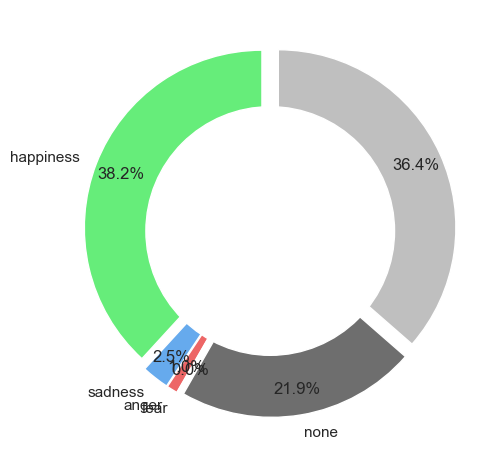

In [55]:
# count label frequencies and save in list
happiness = list(data_aifer['majority_emotions']).count(labels[0])
sadness = list(data_aifer['majority_emotions']).count(labels[1])
anger = list(data_aifer['majority_emotions']).count(labels[2])
fear = list(data_aifer['majority_emotions']).count(labels[3])
none = list(data_aifer['majority_emotions']).count(labels[4])
nothing = list(data_aifer['majority_emotions']).count(labels[5])
ratios = [happiness, sadness, anger, fear, none, nothing]
print(labels)
print(ratios)

# create simple piechart to show ratios between the sentiment labels
create_piechart(ratios, labels=labels, title='Sentiments in the AIFER Tweets')

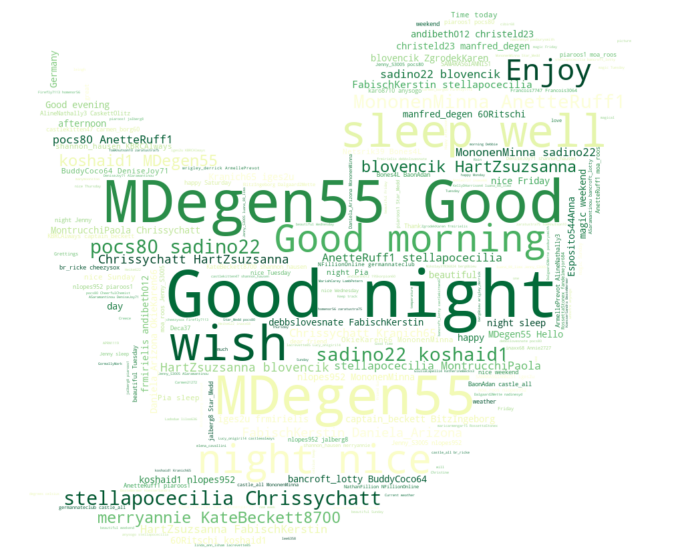

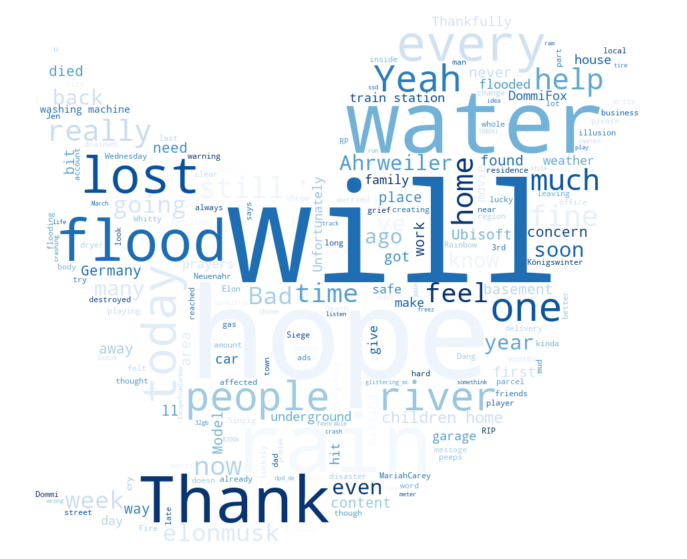

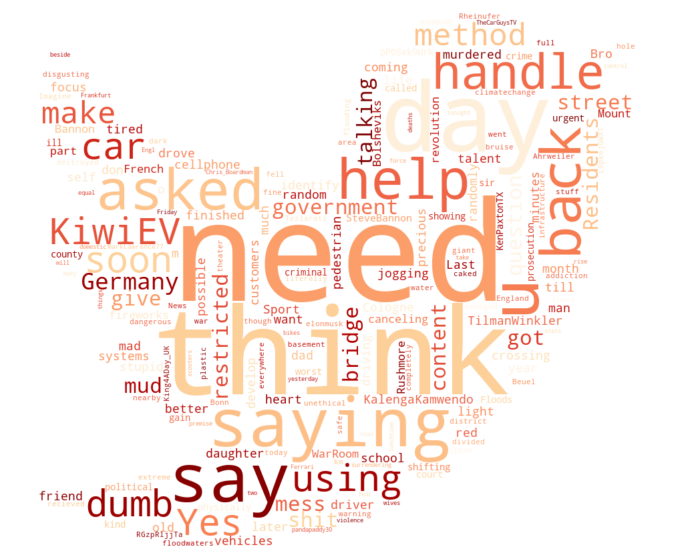

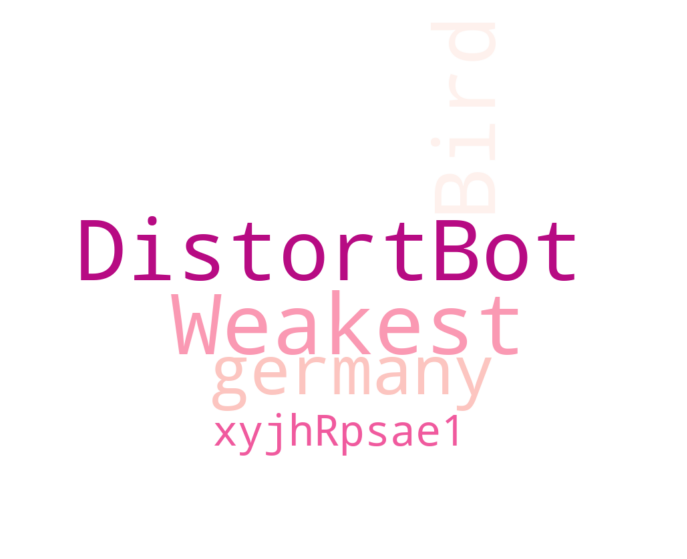

In [56]:
create_pos_neg_tweet_wordcloud(df=data_aifer, labels_col='majority_emotions', labels=labels)

##### Geographic Emotions

In [59]:
# create copy of the dataframe
data_copy = data_aifer.copy()
data_copy['geometry'] = gpd.GeoSeries.from_wkt(data_copy['geom'])

# convert dataframe to geodataframe using the geom column
# data_geo = generate_geodataframe(data_copy)

In [80]:
# TO DO: FIX THIS FUNCTION - the emotions list does not match the length of the df length - figure out why. and then maybe make several maps with individual emotions.... cause this looks ugly

# create an interactive folium map
# for map center USA is 'United States', UK is 'United Kingdom'

folium_map = create_folium_map(df = data_copy, 
                               map_center = 'Germany', 
                               tiles = 'cartodbpositron', 
                               zoom_start = 7, 
                               n_labels = 6, 
                               text_col = 'text', 
                               senti_label_col ='majority_emotions', 
                               senti_aspects = 'aspect_terms'
                              )

# display map
folium_map